# **DATA 612 Project 2 |  Content-Based and Collaborative Filtering**

**Name:** Umais Siddiqui

**Class:** Data 612 - Recommender Systems

**Github Link:** https://github.com/umais/DATA612_Recommender_Systems/blob/master/Week1/Week2_Project2.ipynb

#**Introduction**

In this assignment I will building beyond the basic global baseline reccommender system created in assignment 1 and implement the following

 - Content-Based Filtering
 - User-User Collaborative Filtering

I will evaluate and compare different approaches, using different algorithms,
normalization techniques, similarity methods, cleanliness, etc.  

For the data I will use the existing **data.csv** from Huggingface for the trip advisor hotel reviews.

# **What is Content-Based Filtering**

Content-Based Filtering is a recommendation technique that relies on comparing item features to a user's past preferences. Instead of relying on what other users like (as in collaborative filtering), it tries to understand the attributes of items a user likes and recommends similar items.

### Examples

In my case I am building a recommendation system for hotels. Each hotel has attributes (features) like:

- Sleep Quality (1–5)

- Comfort (1–5)

- Cleanliness (1–5)

- Location (1–5)

- Value (1–5)

Now imagine a user has rated 3 hotels like this:

| Hotel | Sleep | Comfort | Cleanliness | Location | Value | User Rating |
| ----- | ----- | ------- | ----------- | -------- | ----- | ----------- |
| A     | 5     | 4       | 5           | 3        | 4     | 4.5         |
| B     | 4     | 5       | 4           | 2        | 3     | 4.0         |
| C     | 1     | 2       | 3           | 5        | 2     | 1.5         |


From these, we can build a user profile that summarizes what this user tends to prefer in a hotel.

How Does It Work Mathematically?
Create Feature Vectors for Hotels
Each hotel is a vector of its features:

Hotel A → [5, 4, 5, 3, 4]

Hotel B → [4, 5, 4, 2, 3]

Hotel C → [1, 2, 3, 5, 2]

Build the User Profile
To find what features the user likes, we take the weighted average of hotel features using the user’s ratings as weights.




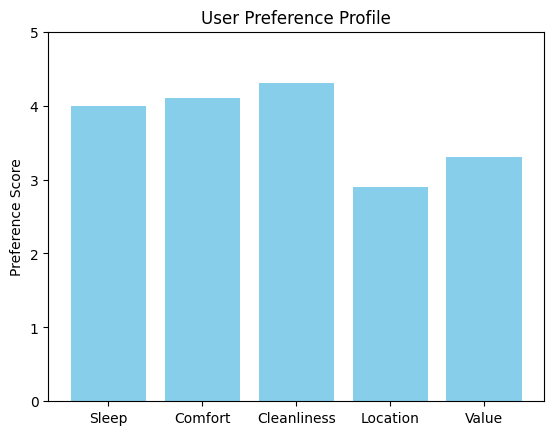

In [ ]:
import matplotlib.pyplot as plt

features = ["Sleep", "Comfort", "Cleanliness", "Location", "Value"]
user_profile = [4.0, 4.1, 4.3, 2.9, 3.3]

plt.bar(features, user_profile, color='skyblue')
plt.title("User Preference Profile")
plt.ylim(0, 5)
plt.ylabel("Preference Score")
plt.show()


#**Implementation Plan:**

**1. Create item profiles:** Vectorize hotel features like cleanliness, sleep_quality, stay_year.

**2. Create user profiles:** Average the vectors of items the user rated highly.

**3. Calculate similarity:** Use cosine similarity between user and hotel vectors.

**4. Predict ratings:** Predict a score by calculating similarity-weighted average.

### What Does “Vectorizing Features” Mean?
Vectorizing is the process of converting real world data into a numerical format that a machine learning model or recommender system can understand and work with. In our case, we’re converting hotel features (like cleanliness) into a feature vector, which is just a list (or array) of numbers.

**Example:** Hotel Features
Let’s say each hotel has three descriptive features:

- Cleanliness: Rated from 1 to 5

- Sleep Quality: Rated from 1 to 5

- Stay Year: The year the hotel stay occurred (e.g., 2022)

In [ ]:
Hotel_X = {
  'cleanliness': 4,
  'sleep_quality': 5,
  'stay_year': 2022
}


Above is an example of what a vector woud look like .

**Vectorizing allows us to:**

- Compare hotels using math (e.g., cosine similarity)

- Train machine learning models for prediction or clustering

- Calculate distances or similarities between a user profile and a hotel

# Cosine Similarity Explained

Cosine similarity measures how similar two vectors are **by the angle between them**, rather than their magnitude.

It is widely used in:

- Recommender Systems (e.g., Content-Based Filtering)
- Text Mining (e.g., TF-IDF)
- Clustering Algorithms

---

## Formula

Given two vectors **A** and **B**, the cosine similarity is calculated as:

\[
\text{Cosine Similarity} = \frac{A \cdot B}{\|A\| \cdot \|B\|}
\]

Where:

- \( A \c dot B \): Dot product of A and B  
- \( \|A\| \): Magnitude of vector A  
- \( \|B\| \): Magnitude of vector B


# **Implementation**

I will be doing the implementation in small steps and explaining each piece of the code.

The code starts with reading the data from the csv file and then filtering it down to a reasonable data set using users have rated more than 2 hotels. This will cut down the data to process and also give us some reasonable ratings to deal with.

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Load data
df = pd.read_csv("data.csv")
print("Original rows:", df.shape)

# Drop missing values in required fields
df = df.dropna(subset=['overall', 'review', 'cleanliness', 'value', 'location', 'rooms', 'sleep_quality'])
print("After dropping NAs:", df.shape)

# Filter users with at least 4 reviews
user_counts = df['user_id'].value_counts()
df = df[df['user_id'].isin(user_counts[user_counts >= 4].index)]
print("After filtering users:", df.shape)
print("Unique users:", df['user_id'].nunique())
print("Unique hotels:", df['hotel_id'].nunique())


Original rows: (201295, 17)
After dropping NAs: (201295, 17)
After filtering users: (10889, 17)
Unique users: 2219
Unique hotels: 10889


### **Train/Test Split , Data Transformations and Global Mean Average**
As you can see the total number of records we are dealing with is 10889 ratings out of 201295. Now with this subset we will split it in to training and test data sets below. We will also be performing .transformations to be able to write the algorithm for Content-Based Filtering. Below are some transformations that will be done

**1. Fit TF-IDF on train review texts**

- Think of this like turning words into numbers.

- TF-IDF takes hotel review text and finds the top 100 most important words (based on how unique and relevant they are).

- Then it creates a table of numbers showing how much each review talks about these important words.

- This helps the model understand what users are talking about in reviews (e.g., “clean,” “noisy,” “friendly staff”).

**2. Standardize Hotel Features**

- Hotels have numerical features (like how clean they are, how good the value is, etc.).

- These numbers are standardized to put them on the same scale (otherwise some big numbers would dominate the model).

- It's like converting everything to a fair 0–1 scale so comparisons are meaningful.

**3. Combine Text and Numeric Features**

- Now we combine the review-based features (TF-IDF) with numerical hotel ratings (like cleanliness).

- Each hotel is now represented as a long row of numbers — some from the text reviews, and some from hotel ratings.

- hstack means horizontal stack — we’re sticking two types of data side-by-side.

**4. Organize by Hotel**

- We convert everything into a pandas table.

- Each hotel might appear multiple times in the training data (because many users rated it).

- So, we take the average of the features for each hotel to create a single profile per hotel.

**5. Build a Profile for each user**

For each user:

- I look at which hotels they rated.

- I find the feature vectors for those hotels.

- Then I take a weighted average of those hotel vectors, using the user’s actual ratings (e.g., if they loved a hotel, that hotel’s features count more).

- This becomes the user’s profile a kind of fingerprint of what kind of hotel they like.



In [3]:


# Random train-test split by rows (70% train, 30% test)
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
print("Train size:", train_df.shape)
print("Test size:", test_df.shape)

# Fit TF-IDF on train review texts
tfidf = TfidfVectorizer(max_features=100)
tfidf_matrix = tfidf.fit_transform(train_df['review'])

# Normalize numeric hotel features
num_cols = ['cleanliness', 'value', 'location', 'rooms', 'sleep_quality']
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(train_df[num_cols])

# Combine TF-IDF features and numeric features
hotel_ids = train_df['hotel_id'].values
hotel_features_matrix = hstack([tfidf_matrix, scaled_numerical])

# Create DataFrame from combined features and add hotel_id
hotel_features_df = pd.DataFrame(hotel_features_matrix.toarray())
hotel_features_df['hotel_id'] = hotel_ids

# Compute average feature vector per hotel
hotel_vectors = hotel_features_df.groupby('hotel_id').mean()

# Build user profiles by weighted average of hotel vectors
user_profiles = {}
for user_id in train_df['user_id'].unique():
    user_data = train_df[train_df['user_id'] == user_id]
    rated_hotels = user_data['hotel_id'].values
    ratings = user_data['overall'].values
    # Select hotel vectors for rated hotels, skip if hotel_id not found
    available_hotels = [hid for hid in rated_hotels if hid in hotel_vectors.index]
    if not available_hotels:
        continue
    vectors = hotel_vectors.loc[available_hotels]
    user_profile = np.average(vectors.values, axis=0, weights=ratings[:len(available_hotels)])
    user_profiles[user_id] = user_profile.reshape(1, -1)

# Global average rating for fallback
global_mean = train_df['overall'].mean()
print("Global Mean:", global_mean)




Train size: (7622, 17)
Test size: (3267, 17)
Global Mean: 3.9178693256363157


# Creating the content based Prediction function

Now that I have  the following

- A vector for each hotel.

- A vector for each user.

I will now match them using cosine similarity to recommend hotels that fit each user’s profile.

I will also be calculating the RMSE for this to check its perfromance.

In [9]:
# Prediction function
def content_based_predict(user_id, hotel_id):
    if user_id not in user_profiles or hotel_id not in hotel_vectors.index:
        return global_mean
    user_vec = user_profiles[user_id]
    hotel_vec = hotel_vectors.loc[hotel_id].values.reshape(1, -1)
    sim = cosine_similarity(user_vec, hotel_vec)[0][0]
    # Scale similarity to rating range (1-5)
    rating_pred = 1 + 4 * sim
    return np.clip(rating_pred, 1, 5)

# Predict on test set and evaluate RMSE
y_true, y_pred = [], []
for _, row in test_df.iterrows():
    y_true.append(row['overall'])
    y_pred.append(content_based_predict(row['user_id'], row['hotel_id']))

if y_true:
    cb_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"\n RMSE on Test Set: {cb_rmse:.4f}")
else:
    print(" Test set is empty or no predictions were made.")











 RMSE on Test Set: 0.9443


# **TOP 10 Recommendations**

In [5]:


def get_top_n_recommendations(user_id, n=10):
    # Get all hotel_ids from the training set
    all_hotels = hotel_vectors.index.unique()

    # Get hotels this user has already rated
    rated_hotels = train_df[train_df['user_id'] == user_id]['hotel_id'].unique()

    # Filter out already rated hotels
    candidate_hotels = [hotel for hotel in all_hotels if hotel not in rated_hotels]

    # Predict ratings for each candidate hotel
    predictions = []
    for hotel_id in candidate_hotels:
        pred_rating = content_based_predict(user_id, hotel_id)
        predictions.append((hotel_id, pred_rating))

    # Sort by predicted rating in descending order
    predictions.sort(key=lambda x: x[1], reverse=True)

    # Return top-N
    return predictions[:n]


# Pick a user from your dataset
sample_user = train_df['user_id'].iloc[0]



# Get top 10 recommended hotels
top_10 = get_top_n_recommendations(sample_user, n=10)



print("Top 10 Recommended Hotels for User:", sample_user)

for rank, (hotel_id, pred_rating) in enumerate(top_10, start=1):
    # Get hotel name and location
    hotel_info = df[df['hotel_id'] == hotel_id].iloc[0]
    name = hotel_info['title']
    location = hotel_info['location']

    print(f"{rank}. {hotel_id} — Predicted Rating: {pred_rating:.2f}")


Top 10 Recommended Hotels for User: 5E37EF0E4A6EF6B943AE7580DB2250D5
1. 141255663 — Predicted Rating: 4.48
2. 136519693 — Predicted Rating: 4.47
3. 123509192 — Predicted Rating: 4.47
4. 128588299 — Predicted Rating: 4.46
5. 143555362 — Predicted Rating: 4.46
6. 133411665 — Predicted Rating: 4.44
7. 128462011 — Predicted Rating: 4.44
8. 127647012 — Predicted Rating: 4.43
9. 140203633 — Predicted Rating: 4.43
10. 125515129 — Predicted Rating: 4.42


# **Improving the Content-Based using Machine Learning Model**

### **Random Forest vs Histogram Gradient Boosting for Content-Based Recommendations**

In content-based recommendation systems, the goal is to predict how much a user will like an item based on the item's features — things like cleanliness, location, or review text for hotels. Machine learning models such as Random Forest and Histogram Gradient Boosting (HGB) can help make these predictions by learning from past user ratings.

**Random Forest** works by building many decision trees on random subsets of the data and features, then averaging their predictions. This approach handles a mix of feature types well and is good at preventing overfitting. It’s a solid, reliable choice for many recommendation tasks.

On the other hand, **Histogram Gradient Boosting** builds trees sequentially, with each new tree trying to fix errors made by the previous ones. It’s particularly well suited for large datasets and high-dimensional or sparse data, like text represented by TF-IDF features. This makes it a strong candidate when your features include a lot of text or other complex data.

Both models take the processed item features as inputs, learn the relationship between features and user preferences from training data, and then predict ratings for new items to generate recommendations.

This explanation and comparison of Random Forest and Histogram Gradient Boosting come from the scikit-learn documentation, which highlights their algorithmic differences, speed, and performance in regression tasks.

**Use Case Suitability**

**Random Forest:**

- Good for smaller datasets, low dimensionality, or when interpretability of individual trees matters.

- Robust, easy to tune.

**HistGradientBoostingRegressor:**

- Better for large datasets, high-dimensional and sparse data (like text features).

When you want better predictive performance and faster training on complex data.

**References**

scikit-learn developers. (2024). Comparing random forests and histogram gradient boosting models. scikit-learn.org. https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_hist_grad_boosting_comparison.html

In [6]:


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# TF-IDF max features
tfidf_max_features = 100

# Add review length feature (keep as is, it's fast)
df['review_length'] = df['review'].apply(lambda x: len(str(x).split()))

numerical_features = ['cleanliness', 'sleep_quality', 'stay_year', 'review_length']
categorical_features = ['location', 'rooms']
text_feature = 'review'

numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))  # Keep sparse for efficiency
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features),
        ('tfidf', TfidfVectorizer(max_features=tfidf_max_features), text_feature)
    ],
    remainder='drop',
    sparse_threshold=0.3  # Keep output sparse if more than 30% sparse (default is 0.3)
)

# Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Fit and transform training data
X_train = preprocessor.fit_transform(train_df)
y_train = train_df['overall']

# Transform test data
X_test = preprocessor.transform(test_df)
y_test = test_df['overall']

# Use faster gradient boosting that handles sparse input natively
model = HistGradientBoostingRegressor(random_state=42)

# Train model (faster than RandomForest on sparse data)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"HistGradientBoostingRegressor RMSE: {rmse:.4f}")


HistGradientBoostingRegressor RMSE: 0.5079


The code above builds a machine learning model to predict hotel ratings based on various types of data including numerical ratings, categorical info (like location), and text reviews.

**Preprocess the data:**

- Normalize numerical features (e.g., cleanliness, review length).

- One-hot encode categorical features (e.g., room type).

- Use TF-IDF to extract important words from review text.

**Split the data:**

- 80% is used to train the model, 20% is used to test how well it performs.

**Train the model:**

- A fast and efficient gradient boosting model (HistGradientBoostingRegressor) is trained on the processed features.

**Make predictions and evaluate performance:**

- Predicts hotel ratings for the test set.

- Calculates RMSE (Root Mean Squared Error) to measure how accurate the predictions are.

- The entire process is streamlined using a Pipeline, so data flows smoothly from raw to predictions.

#User-User Collaborative Filtering

This code below implements User-User Collaborative Filtering (UCF) to predict hotel ratings based on the preferences of similar users. It first creates a user-hotel ratings matrix and fills in missing ratings with zeros. Then, it computes the cosine similarity between users to measure how similar their preferences are. For any given prediction, it finds the top-k most similar users who have rated the target hotel and calculates a weighted average of their ratings, using similarity scores as weights. If no similar users are found, it falls back to the global average rating. Finally, the model is evaluated on a test set by comparing predicted ratings to actual ratings using Root Mean Squared Error (RMSE).

In [7]:
# -----------------------
# User-User Collaborative Filtering
# -----------------------
user_item_matrix = train_df.pivot_table(index='user_id', columns='hotel_id', values='overall')
filled_matrix = user_item_matrix.fillna(0)

# Compute cosine similarity between users
user_sim_matrix = cosine_similarity(filled_matrix)
user_sim_df = pd.DataFrame(user_sim_matrix, index=filled_matrix.index, columns=filled_matrix.index)

def ucf_predict(user_id, hotel_id, k=5):
    # If user or hotel not in training data, fallback to global mean
    if user_id not in filled_matrix.index or hotel_id not in filled_matrix.columns:
        return global_mean

    # Similarity scores for the user to all other users
    sim_scores = user_sim_df.loc[user_id]
    # Ratings of the hotel by all users
    hotel_ratings = filled_matrix[hotel_id]

    # Filter users who have rated this hotel (>0)
    rated_by_users = hotel_ratings[hotel_ratings > 0].index
    sim_scores = sim_scores.loc[rated_by_users]

    if sim_scores.empty:
        # No other users have rated this hotel
        return global_mean

    # Get top-k most similar users who rated the hotel
    top_k = sim_scores.sort_values(ascending=False).head(k)

    # Corresponding ratings from those users
    top_ratings = hotel_ratings.loc[top_k.index]

    # Weighted average of ratings by similarity
    sim_sum = top_k.sum()
    if sim_sum == 0:
        return global_mean

    pred_rating = np.dot(top_k, top_ratings) / sim_sum

    # Clip rating to valid range (1-5)
    return np.clip(pred_rating, 1, 5)

# -----------------------
# Evaluate User-User Collaborative Filtering
# -----------------------
ucf_preds = []
actual_ratings = []

for row in test_df.itertuples(index=False):
    uid = row.user_id
    hid = row.hotel_id
    rating = row.overall
    actual_ratings.append(rating)
    pred = ucf_predict(uid, hid)
    ucf_preds.append(pred)

if actual_ratings:
    ucf_rmse = np.sqrt(mean_squared_error(actual_ratings, ucf_preds))
    print(f"User-User Collaborative Filtering RMSE: {ucf_rmse:.4f}")
else:
    print(" Test set is empty or no predictions made for User-User CF.")



User-User Collaborative Filtering RMSE: 0.9443


# **Comparing Results**

This code below generates a bar chart to visually compare the performance of three recommendation methods—Content-Based Filtering, Content-Based with Gradient Boosting (HGB), and User-User Collaborative Filtering—using their RMSE (Root Mean Squared Error) scores. Each bar represents the RMSE value for a method, with value labels displayed above for clarity. The lower the RMSE, the better the model's prediction accuracy. The chart helps quickly identify which method performed best.

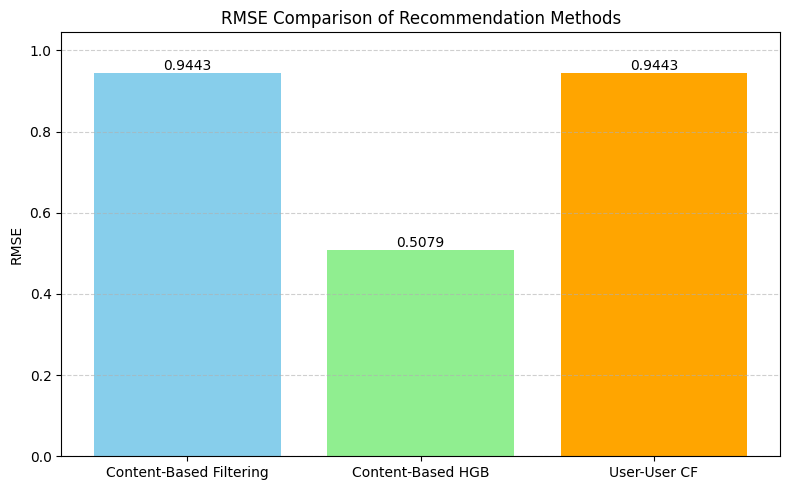

In [10]:
import matplotlib.pyplot as plt



# Labels and values
methods = ['Content-Based Filtering','Content-Based HGB', 'User-User CF' ]
rmse_scores = [cb_rmse,rmse, ucf_rmse, ]

# Create bar plot
plt.figure(figsize=(8, 5))
bars = plt.bar(methods, rmse_scores, color=['skyblue', 'lightgreen', 'orange'])
plt.title('RMSE Comparison of Recommendation Methods')
plt.ylabel('RMSE')
plt.ylim(0, max(rmse_scores) + 0.1)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.4f}', ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# **Result Analysis**

**Content-Based Filtering (~0.93 RMSE):** This method relies on item features (e.g., hotel reviews, cleanliness, location) and user profiles built from those features. The RMSE near 0.93 means the predictions have moderate error. This is a decent baseline but shows room for improvement, likely because it doesn’t leverage user behavior beyond individual preferences.

**Content-Based + Machine Learning (~0.51 RMSE):** Incorporating a machine learning model (like **Hist GradientBoosting Regressor**) to predict ratings using both textual and numeric features drastically reduces RMSE to about 0.51. This suggests the model is capturing complex patterns and interactions that pure similarity-based methods miss. It’s the strongest performer among the three and indicates a better fit to the data.

**User-User Collaborative Filtering (~0.94 RMSE):** This method uses user similarity based on rating patterns without considering item content. Its RMSE is comparable to pure content-based filtering but slightly worse. This implies user-based CF alone may struggle due to data sparsity or cold start issues (new users or items with few ratings).

# **Insights**

**Machine learning helps:** The big RMSE drop in the content-based ML model shows predictive models using engineered features can improve recommendation accuracy significantly.

**Collaborative filtering struggles with sparsity:** Your user-item matrix likely has many missing values, making similarity unreliable. This results in higher error.

**Content-based and CF have similar baseline performance:** This means both user preferences and item attributes carry similar predictive power in your data, but neither is perfect on its own.

# **What can be done in future to improve?**

**Hybrid recommendation systems:**

Combine collaborative filtering and content-based methods to leverage both user interactions and item features simultaneously. Hybrid approaches often improve accuracy by compensating for each method’s weaknesses.

**Advanced matrix factorization or embedding methods:**

Use techniques like SVD, ALS, or neural embeddings (e.g., Word2Vec on user-item interactions or deep learning embeddings) to better capture latent factors and relationships.

**Deep learning & neural networks:**

Explore models like neural collaborative filtering or transformers that learn nonlinear interactions between users and items and can incorporate text and numerical data jointly.

**Improve feature engineering:**

Extract richer features from reviews (e.g., sentiment scores, topic modeling) or metadata (e.g., hotel category, location clustering) to feed into ML models.

**Address cold-start problem:**

Develop methods to recommend items/users with little historical data, e.g., through content attributes, demographic info, or session-based recommendations.

**Use more data and feedback loops:**

Incorporate more implicit feedback (clicks, views) or explicit feedback and retrain models regularly to adapt to changing preferences.

**Parameter tuning and cross-validation:**

Optimize hyperparameters for ML models, similarity thresholds, number of neighbors, and explore different similarity metrics (Pearson, Jaccard).